In [1]:
from dataset import WelQrateDataset
from mol_utils.scaffold_split import generate_scaffolds
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import DataStructs
import numpy as np
from rdkit.Chem import Draw
from IPython.display import display
from rdkit.Chem import rdFMCS


In [2]:
name = "AID1798"
dataset_2d = WelQrateDataset(name, root ='../dataset', mol_repr ='2dmol', task_type='classification')
smiles_list = dataset_2d.smiles
print(len(smiles_list))

dataset stored in ../dataset/AID1798
Dataset AID1798 loaded.
Number of active molecules: 164
Number of inactive molecules: 60542
60706


In [3]:
active_smiles = [data.smiles for data in dataset_2d if data.y == 1]
all_smiles = [data.smiles for data in dataset_2d]

In [4]:
all_cid = [data.pubchem_cid.item() for data in dataset_2d]

print(len(all_cid) == len(set(all_cid)))
len(all_smiles) == len(set(all_smiles))


True


True

In [5]:
active_mols = [Chem.MolFromSmiles(s) for s in active_smiles]
all_mols = [Chem.MolFromSmiles(s) for s in all_smiles]

In [6]:
def calculate_ecfp(scaffold_mols):
    ecfp = []
    # error = []
    for mol in scaffold_mols:
        if mol is None:
            raise ValueError('Molecule is invalid')
        else:
            list_bits_fingerprint = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=1024, useFeatures=True)
            ecfp.append(list_bits_fingerprint)
    return ecfp

In [30]:
active_ecfp = calculate_ecfp(active_mols)
all_ecfp = calculate_ecfp(all_mols)

In [31]:
sim_matrix  = np.zeros((len(active_ecfp), len(all_ecfp)))
sim_matrix.shape

(164, 60706)

In [32]:
for i in range(sim_matrix.shape[0]):
    for j in range(i+1, sim_matrix.shape[1]):
        if active_ecfp[i] is None or all_ecfp[j] is None:
            sim_matrix[i,j] = None
        else:
            sim_matrix[i,j] = DataStructs.TanimotoSimilarity(active_ecfp[i], all_ecfp[j])

In [33]:
sim_matrix

array([[0.        , 0.17857143, 0.11940299, ..., 0.18      , 0.11666667,
        0.1       ],
       [0.        , 0.        , 0.12857143, ..., 0.18867925, 0.16393443,
        0.11320755],
       [0.        , 0.        , 0.        , ..., 0.28571429, 0.15942029,
        0.15254237],
       ...,
       [0.        , 0.        , 0.        , ..., 0.09589041, 0.17333333,
        0.1875    ],
       [0.        , 0.        , 0.        , ..., 0.18965517, 0.11594203,
        0.12068966],
       [0.        , 0.        , 0.        , ..., 0.24561404, 0.25396825,
        0.1754386 ]])

In [34]:
def get_top_5_values_and_indices_per_row(similarity_matrix):
    m, n = similarity_matrix.shape
    top_values = []
    top_indices = []

    for i in range(m):
        # Create a mask for the upper triangle (excluding diagonal)
        mask = np.arange(n) > i

        # Extract valid elements and their indices
        valid_elements = similarity_matrix[i, mask]
        valid_indices = np.arange(n)[mask]

        # If less than 5 valid elements, pad with minimum value
        if len(valid_elements) < 5:
            pad_length = 5 - len(valid_elements)
            min_value = np.min(similarity_matrix) - 1  # Use a value lower than any in the matrix
            valid_elements = np.pad(valid_elements, (0, pad_length), constant_values=min_value)
            valid_indices = np.pad(valid_indices, (0, pad_length), constant_values=-1)

        # Sort and get top 5 values and indices
        top_5_indices = np.argsort(valid_elements)[-5:][::-1]
        top_5_values = valid_elements[top_5_indices]
        top_5_original_indices = valid_indices[top_5_indices]

        top_values.append(top_5_values)
        top_indices.append(top_5_original_indices)

    return np.array(top_values), np.array(top_indices)

In [35]:
top_values, top_indices = get_top_5_values_and_indices_per_row(sim_matrix)

In [41]:
# active num
i = 2
print(top_indices[i,:])
print(top_values[i,:])
top5_smiles = [all_smiles[j] for j in top_indices[i,:]]
top5_scores = top_values[i,:]
top5_indices = top_indices[i,:]

ref_smiles = active_smiles[i]
print(ref_smiles)
top5_smiles

[  435 54542  4550  4236 16618]
[0.84090909 0.60784314 0.6        0.55319149 0.51724138]
CC(=O)Nc1ccc(S(=O)(=O)Nc2nc3ccccc3nc2Sc2nncn2C)cc1


['Cn1cnnc1Sc1nc2ccccc2nc1NS(=O)(=O)c1ccccc1',
 'CC(=O)Nc1ccc(S(=O)(=O)Nc2nc3ccccc3nc2N2CCCC2)cc1',
 'Cn1ccnc1Sc1nc2ccccc2nc1NS(=O)(=O)c1ccccc1',
 'CCOc1nc2ccccc2nc1NS(=O)(=O)c1ccccc1',
 'Cn1cnnc1SCC(=O)Nc1ccc2nc(SCc3ccccc3)sc2c1']

In [42]:
def plot_smiles_with_list(ref_smiles, smiles_list, display_molid=True):
    
    main_molecule = Chem.MolFromSmiles(ref_smiles)
    molecules = [Chem.MolFromSmiles(s) for s in smiles_list]
    all_molecules = [main_molecule] + molecules
    
    if display_molid:
        legends = ["Ref active Smiles"] + [f"Mol: {idx} Similarity: {score:.2f}" for score, idx in zip(top5_scores, top5_indices)]
    else:
        legends = ["Ref active Smiles"] + [f"Similarity: {score:.2f}" for score in top5_scores]
        
    return Draw.MolsToGridImage(all_molecules, molsPerRow=len(all_molecules), legends=legends)

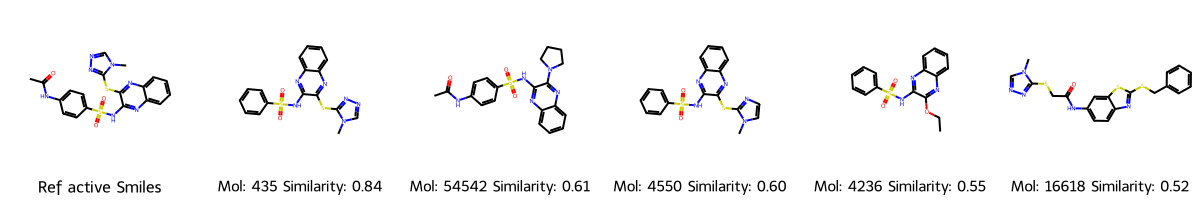

In [43]:
plot_smiles_with_list(ref_smiles, top5_smiles)

## Active Molecules Similarity 

In [16]:

sim_matrix  = np.zeros((len(active_ecfp), len(active_ecfp)))
sim_matrix.shape

for i in range(sim_matrix.shape[0]):
    for j in range(i+1, sim_matrix.shape[1]):
        if active_ecfp[i] is None or active_ecfp[j] is None:
            sim_matrix[i,j] = None
        else:
            sim_matrix[i,j] = DataStructs.TanimotoSimilarity(active_ecfp[i], active_ecfp[j])

[126  70  35  46  61]
[0.41935484 0.37878788 0.34848485 0.33823529 0.33333333]
CCN(CC(=O)Nc1ccc2c(c1)OCCO2)c1nc(-c2cccnc2)nc2ccccc12
['CC(C)n1c(N2CCN(CC(=O)Nc3ccc4c(c3)OCCO4)CC2)nc2ccccc21', 'Cc1cc(C)cc(OCC(=O)Nc2cccc(-c3nnc(-c4ccco4)o3)c2)c1', 'O=C(CN1CCN(S(=O)(=O)c2cc(Cl)ccc2Cl)CC1)Nc1ccc2c(c1)OCCO2', 'CCn1c(=O)cc(SCC(=O)N2CCN(c3ccccn3)CC2)c2ccccc21', 'Cc1ccc(C(=O)COc2cccc(NC(=O)c3ccco3)c2)cc1']


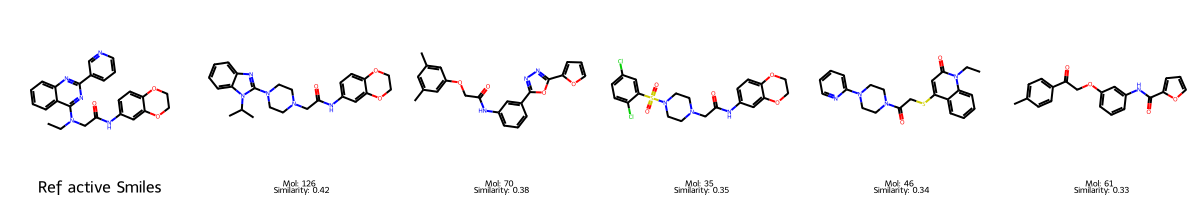

In [17]:
top_values, top_indices = get_top_5_values_and_indices_per_row(sim_matrix)

# active num
i = 4
print(top_indices[i,:])
print(top_values[i,:])
top5_smiles = [all_smiles[j] for j in top_indices[i,:]]
top5_scores = top_values[i,:]
top5_indices = top_indices[i,:]

ref_smiles = active_smiles[i]
print(ref_smiles)
print(top5_smiles)

plot_smiles_with_list(ref_smiles, top5_smiles)

Results for i=0:
Reference SMILES: Cc1ccc(C)c(OCC(O)CN2C(C)CCCC2C)c1
Top 5 SMILES: ['CCOC(=O)N1CCN(CC(O)COc2ccccc2C(C)C)CC1', 'CCOC(=O)C1CCCN(CC(O)COc2ccc(OC)cc2C(C)(C)C)C1', 'C=CCc1ccccc1OCC(O)CN1CCN(C(=O)OCC)CC1', 'CCC(=O)c1ccc(OCC(O)Cn2c(C)nc3ccccc32)cc1', 'CC(=O)N1CCN(c2ccccc2NC(=O)COc2cc(C)ccc2C(C)C)CC1']


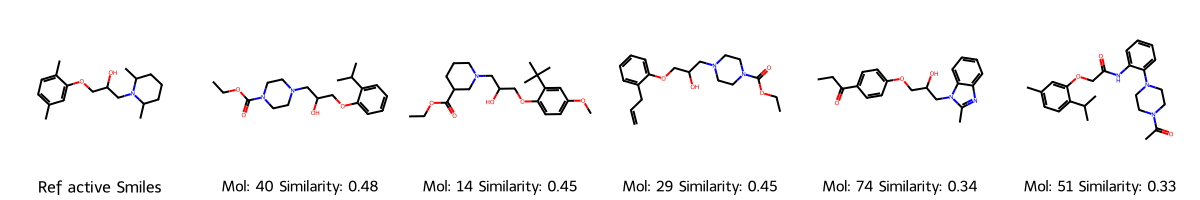

Results for i=1:
Reference SMILES: CCOC(=O)N1CCN(C2=Nc3cccc4cccc2c34)CC1
Top 5 SMILES: ['CCOC(=O)N1CCN(CC(O)COc2ccccc2C(C)C)CC1', 'CCOC(=O)C1CCCN(C(=O)CN2CCN(Cc3ccc(Cl)cc3)C2=O)C1', 'CCOC(=O)C1CCCN(CC(=O)NC2=Nc3ccccc3N=C(C)C2c2ccccc2)C1', 'CCOC(=O)N1CCC(NCCNC(=O)c2ccccc2Cl)CC1', 'CCOC(=O)N1CCC(NCCNC(=O)c2ccc(Cl)cc2)CC1']


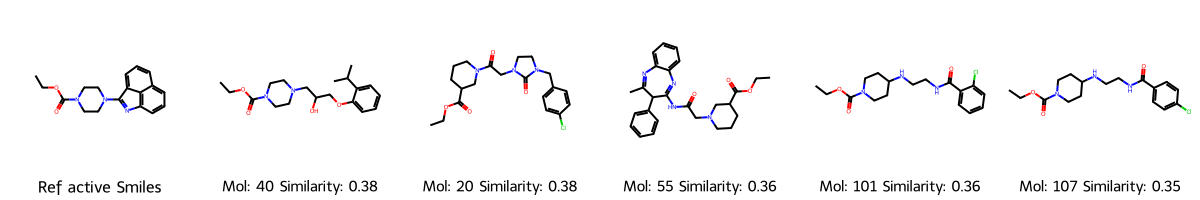

Results for i=2:
Reference SMILES: CC(=O)Nc1ccc(S(=O)(=O)Nc2nc3ccccc3nc2Sc2nncn2C)cc1
Top 5 SMILES: ['CC(=O)Nc1c2c3c(cccc3n(C)c1=O)C(=O)c1ccccc1-2', 'CC(C)n1c(N2CCN(CC(=O)Nc3ccc4c(c3)OCCO4)CC2)nc2ccccc21', 'Cc1cccc(-n2c(N)cc(=O)nc2SCC(=O)Nc2ccccc2)c1', 'CC(=O)c1cccc(NC(=O)C2CCCN(S(=O)(=O)c3cccc4cccnc34)C2)c1', 'CCOC(=O)c1ccc(NC(=O)Nc2ccc(OC)c(OC)c2)cc1']


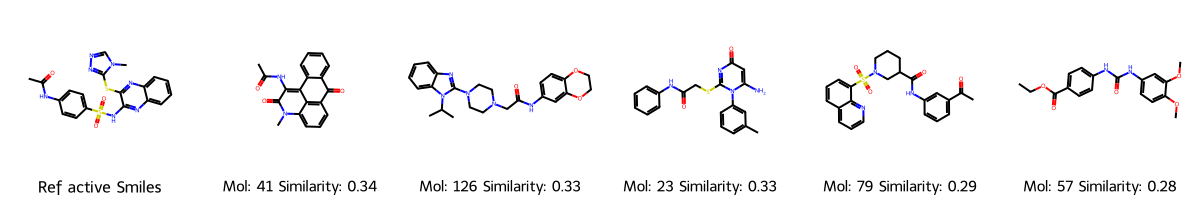

Results for i=3:
Reference SMILES: C=CCn1c(=O)/c(=C/c2ccc(O)cc2)s/c1=C(/C#N)c1nnc2n1CCCCC2
Top 5 SMILES: ['N=c1c2c3c(sc2nc2n1CCCCC2)CCCCC3', 'CCC(=O)c1ccc(OCC(O)Cn2c(C)nc3ccccc32)cc1', 'CCCCCn1c(=O)[nH]c2cc(C(=O)NCCN(CC)CC)ccc2c1=O', 'COc1ccc(C2C(C(C)=O)=C(C)N=c3s/c(=C\\c4cc(C)n(C)c4C)c(=O)n32)c(OC)c1', 'C=CCn1c(/N=C/c2ccc(N(C)C)cc2)nc2ccccc21']


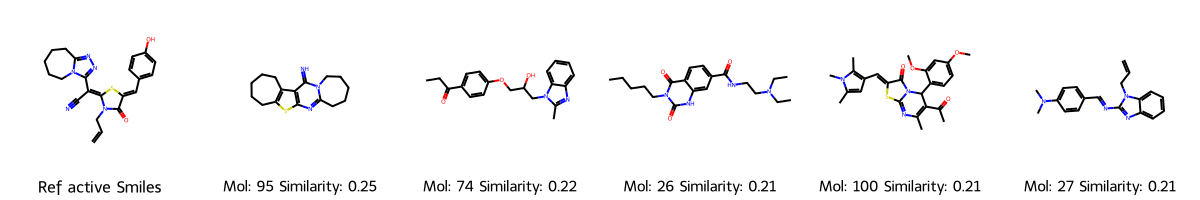

Results for i=4:
Reference SMILES: CCN(CC(=O)Nc1ccc2c(c1)OCCO2)c1nc(-c2cccnc2)nc2ccccc12
Top 5 SMILES: ['CC(C)n1c(N2CCN(CC(=O)Nc3ccc4c(c3)OCCO4)CC2)nc2ccccc21', 'Cc1cc(C)cc(OCC(=O)Nc2cccc(-c3nnc(-c4ccco4)o3)c2)c1', 'O=C(CN1CCN(S(=O)(=O)c2cc(Cl)ccc2Cl)CC1)Nc1ccc2c(c1)OCCO2', 'CCn1c(=O)cc(SCC(=O)N2CCN(c3ccccn3)CC2)c2ccccc21', 'Cc1ccc(C(=O)COc2cccc(NC(=O)c3ccco3)c2)cc1']


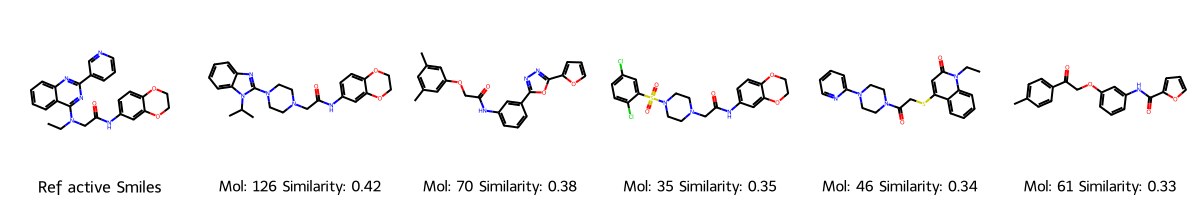

Results for i=5:
Reference SMILES: Cc1nn(-c2ccccc2)c(C)c1C(=O)OC/C(O)=C(\C#N)c1nc2ccccc2[nH]1
Top 5 SMILES: ['N#CC1(c2nc3ccccc3[nH]2)CC1c1ccc2c(c1)OCO2', 'CCC(=O)c1ccc(OCC(O)Cn2c(C)nc3ccccc32)cc1', 'Cc1ccc2nc(Nc3ccc4[nH]c(=O)[nH]c4c3)c(-n3nc(C)cc3C)nc2c1', 'Cc1nn(-c2ccccc2)c(Cl)c1C(=O)N1CCN(c2ncnc3c2cnn3-c2ccccc2)CC1', 'CC(C)OC(=O)c1c2nc3ccccc3nc2n2c1[nH]c(=O)c1ccccc12']


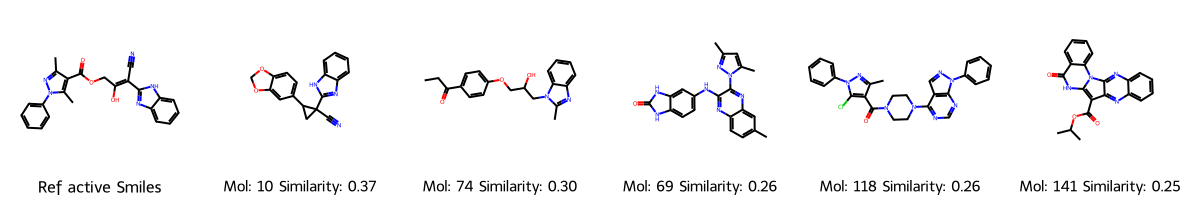

In [29]:

for i in range(0, 6):
    print(f"Results for i={i}:")
    top5_smiles = [all_smiles[j] for j in top_indices[i, :]]
    top5_scores = top_values[i, :]
    top5_indices = top_indices[i, :]
    ref_smiles = active_smiles[i]
    print("Reference SMILES:", ref_smiles)
    print("Top 5 SMILES:", top5_smiles)

    img = plot_smiles_with_list(ref_smiles, top5_smiles, display_molid=True)
    display(img)

## Maximum Common Substructure (MCS) Search

In [19]:
from rdkit import Chem
from rdkit.Chem import AllChem, BRICS
from collections import Counter

def find_frequent_substructures(smiles_list, min_atoms=3):
    mols = [Chem.MolFromSmiles(smiles) for smiles in smiles_list]
    all_fragments = []
    
    for mol in mols:
        # Generate BRICS fragments
        fragments = list(BRICS.BRICSDecompose(mol, minFragmentSize=min_atoms))
        all_fragments.extend(fragments)
    
    # Count occurrences of each fragment
    fragment_counts = Counter(all_fragments)
    
    # Convert SMILES to canonical SMILES for consistency
    canonical_fragments = [(Chem.MolToSmiles(Chem.MolFromSmiles(frag)), count) 
                           for frag, count in fragment_counts.items()]
    
    # Sort by frequency, descending
    return sorted(canonical_fragments, key=lambda x: x[1], reverse=True)

In [44]:
frequent_substructures = find_frequent_substructures(all_smiles)[:10]  # Top 5
freq_substructure_smiles = [smarts for smarts, _ in frequent_substructures]
for smarts, count in frequent_substructures:
    print(f"Substructure (count: {count}): {smarts}")

Substructure (count: 8449): [16*]c1ccccc1
Substructure (count: 7753): [1*]C(=O)C[4*]
Substructure (count: 6095): [3*]OCC
Substructure (count: 4889): [5*]N1CCN([5*])CC1
Substructure (count: 3564): [5*]N1CCOCC1
Substructure (count: 3146): [1*]C(=O)C[8*]
Substructure (count: 2044): [1*]C(=O)N[5*]
Substructure (count: 1977): [16*]c1ccc(OC)cc1
Substructure (count: 1733): [1*]C(=O)CO[3*]
Substructure (count: 1719): [14*]c1ccco1


In [21]:
def plot_substructures(smiles_list, counts):
    molecules = []
    legends = []
    
    for smiles, count in zip(smiles_list, counts):
        mol = Chem.MolFromSmiles(smiles)
        if mol is not None:
            # Replace dummy atoms with methyl groups for visualization
            for atom in mol.GetAtoms():
                if atom.GetAtomicNum() == 0:  # dummy atom
                    atom.SetAtomicNum(6)  # carbon
                    atom.SetNumExplicitHs(3)  # 3 hydrogens
            
            # Generate 2D coordinates for the molecule
            AllChem.Compute2DCoords(mol)
            
            molecules.append(mol)
            legends.append(f"Count: {count}")
    
    # Create the image
    img = Draw.MolsToGridImage(molecules, molsPerRow=5, subImgSize=(300,300), legends=legends)
    return img

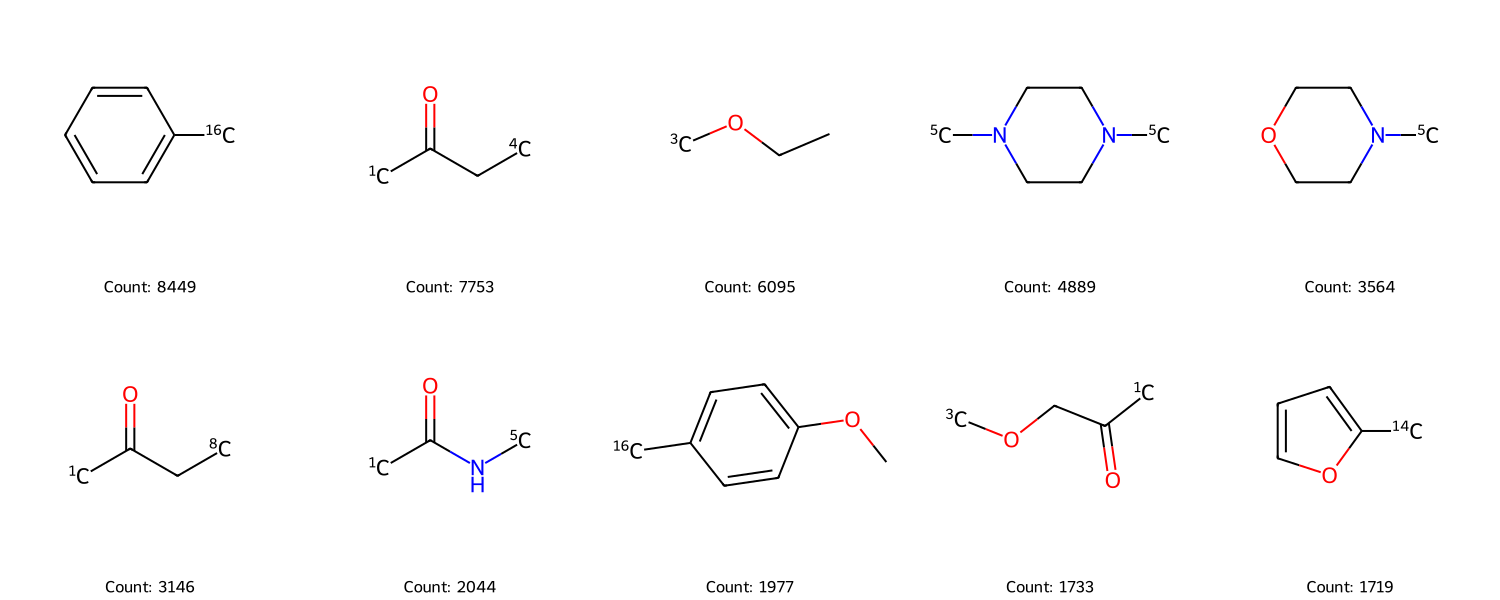

In [45]:
# Example usage
freq_substructure_smiles = [smarts for smarts, _ in frequent_substructures]
freq_substructure_counts = [count for _, count in frequent_substructures]

# Generate and display the image
img = plot_substructures(freq_substructure_smiles, freq_substructure_counts)
img  